In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import nmc_verification.nmc_vf_base as nvb
import nmc_verification.nmc_vf_method as nvm
import nmc_verification.nmc_vf_product as nvp
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt

在该nmc_vf_product层的程序库中，检验程序不再以简单的numpy数组作为观测和预报的数据输入，而是基于[sta_data](https://www.showdoc.cc/nmc?page_id=3744334022014027)或[grid_data](https://www.showdoc.cc/nmc?page_id=3744305814437976)数据形式的预报和观测数据作为输入。由于sta_data和grid_data中自带了时空坐标信息，因此为预报分组或者在检验结果中自动标记类别提供了方便。在nmc_vf_product也包含了数值型检验指标、图表型检验产品制作的功能，它是在nmc_vf_method基础上的进一步封装，进一步提高便利性。本模块包含数值型检验指标的计算方法，为对其进行介绍，以下先对测试数据进行一个简单的介绍。

### 测试数据集：  
 **观测数据** ： 2019年全年2m温度观测数据，时间间隔3小时（1月1日02时），每个时刻包含6个站点（54398，54410，54416，54419，54499，54412）  
   
 **预报数据** ：  
    **ECMWF：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  
   
    **GRAPES_GFS：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  


In [2]:
#设置数据路径的通配格式
dir_ob = r"H:\test_data\input\nvp\ob\temp_2m\BTYYMMDDHH.000"
dir_ec = r"H:\test_data\input\nvp\ec\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
dir_grapes = r"H:\test_data\input\nvp\grapes\temp_2m\YYMMDD\BTYYMMDDHH.TTT"

In [3]:
time0 = datetime.datetime(2019,7,1,20,0)   
dh = 12
path = nvb.get_path(dir_ob,time0)
sta_ob= nvb.read_stadata_from_micaps3(path)   #读取一个时刻的观测数据示例，并打印显示
print(sta_ob)

   level                time  dtime     id    lon   lat      data0
0      0 2019-07-01 20:00:00      0  54398  116.6  40.1  31.400000
1      0 2019-07-01 20:00:00      0  54410  116.1  40.6  20.400000
2      0 2019-07-01 20:00:00      0  54416  116.9  40.4  29.500000
3      0 2019-07-01 20:00:00      0  54419  116.6  40.4  28.500000
4      0 2019-07-01 20:00:00      0  54499  116.2  40.2  31.200001
5      0 2019-07-01 20:00:00      0  54412  116.6  40.7  27.900000


In [4]:
path = nvb.get_path(dir_ec,time0,dh)
grd_ec = nvb.read_griddata_from_micaps4(path)  #读取一个ec预报数据场示例
nvb.set_griddata_coords(grd_ec,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["ecmwf"])
print(grd_ec)                                  #打印显示

<xarray.DataArray 't2m' (member: 1, level: 1, time: 1, dtime: 1, lat: 7, lon: 7)>
array([[[[[[25.2, 26.9, 26.2, 27. , 26.3, 26.2, 25.3],
           [21.1, 23.9, 26.4, 25.9, 25.8, 25. , 25.5],
           [19.7, 19.7, 21.6, 25.6, 25.7, 24.6, 24.5],
           [20.1, 20.7, 20.9, 19.1, 22.4, 19.1, 19.7],
           [18.8, 15.4, 17.6, 16.6, 19.4, 18.7, 19.1],
           [16.4, 16.3, 15.1, 15.8, 16.1, 17. , 16.4],
           [16.1, 15.7, 15.7, 16.2, 14.9, 16.2, 16.1]]]]]])
Coordinates:
  * member   (member) <U5 'ecmwf'
  * level    (level) float64 -2.147e+09
  * time     (time) datetime64[ns] 2019-07-01T20:00:00
  * dtime    (dtime) int32 12
  * lat      (lat) float64 39.0 39.5 40.0 40.5 41.0 41.5 42.0
  * lon      (lon) float64 115.0 115.5 116.0 116.5 117.0 117.5 118.0
Attributes:
    dtime_type:  hour


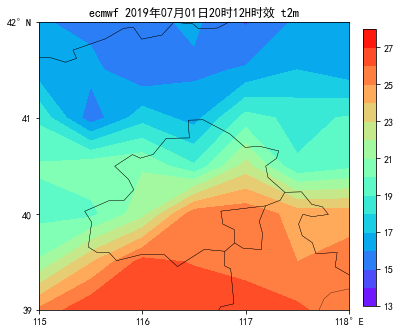

In [5]:
nvb.plot_tools.contourf_2d_grid(grd_ec)   #以图片形式显示

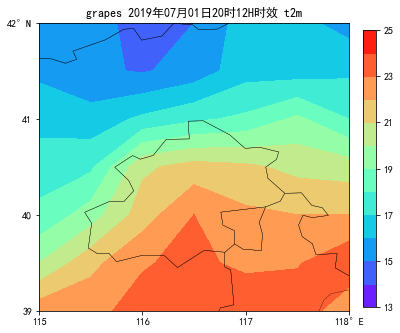

In [6]:
path = nvb.get_path(dir_grapes,time0,dh)
grd_grapes = nvb.read_griddata_from_micaps4(path)
nvb.set_griddata_coords(grd_grapes,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["grapes"])
nvb.plot_tools.contourf_2d_grid(grd_grapes)     #以图片形式显示一个grapes预报场

  在做预报检验时，数据提取和检验计算的通常是交织在一起的，在本程序中的nmc_vf_method模块中也是如此，在nmc_vf_method中至少计算检验中间量是和数据提取是交织在一起的。有时，我们面对一批预报和观测数据要开展检验工作时，事先并不知道后期要计算什么检验指标，这时需要反复尝试。由于数据提取和检验技术的代码交织在一起，意味着每次增删或更改检验指标时，数据提取的部分也需要重新运行一遍。另外上述问题也意味着想把数据提取部分的代码做进一步的封装难以实现或没有意义。  
  本程序库则为上述问题提供了解决方案，基于nvb_vf_base和nvb_vf_product中的函数，可以将检验过程分割以下三个部分：   
    1.数据收集(文件读取，[拼接合并](https://www.showdoc.cc/nmc?page_id=3777135637659548)）  
    2.[数据选取](https://www.showdoc.cc/nmc?page_id=3777179081910063)  
    3.检验计算   
 这为检验程序的进一步模块化提供了基础。以下结合具体的例子进行说明  

In [7]:
###################以下开始为数据收集部分的程序
station = copy.deepcopy(sta_ob)
station.iloc[:,-1] = nvb.IV         
print(station) #站点内容为缺省值，当其作为读取站点数据的参数时，如果站点文件中某个站号不存在时,返回结果中该站点保持为缺省值

   level                time  dtime     id    lon   lat   data0
0      0 2019-07-01 20:00:00      0  54398  116.6  40.1  999999
1      0 2019-07-01 20:00:00      0  54410  116.1  40.6  999999
2      0 2019-07-01 20:00:00      0  54416  116.9  40.4  999999
3      0 2019-07-01 20:00:00      0  54419  116.6  40.4  999999
4      0 2019-07-01 20:00:00      0  54499  116.2  40.2  999999
5      0 2019-07-01 20:00:00      0  54412  116.6  40.7  999999


In [8]:
ob_sta_all = None
time0 = datetime.datetime(2019,1,1,2,0)
time_end = datetime.datetime(2020,1,1,2,0)
while time0 < time_end:
    path = nvb.get_path(dir_ob,time0)
    sta = nvb.read_stadata_from_micaps3(path,station = station,time = time0,dtime = 0,level = 0,data_name = "ob")
    ob_sta_all = nvb.combine_join(ob_sta_all,sta)
    time0 += datetime.timedelta(hours = 3)
print(ob_sta_all)

       level                time  dtime     id    lon   lat    ob
0          0 2019-01-01 02:00:00      0  54398  116.6  40.1  -9.5
1          0 2019-01-01 02:00:00      0  54410  116.1  40.6 -14.6
2          0 2019-01-01 02:00:00      0  54416  116.9  40.4 -12.9
3          0 2019-01-01 02:00:00      0  54419  116.6  40.4 -10.6
4          0 2019-01-01 02:00:00      0  54499  116.2  40.2  -8.5
...      ...                 ...    ...    ...    ...   ...   ...
17323      0 2019-12-31 23:00:00      0  54410  116.1  40.6 -10.9
17324      0 2019-12-31 23:00:00      0  54416  116.9  40.4 -14.0
17325      0 2019-12-31 23:00:00      0  54419  116.6  40.4 -13.3
17326      0 2019-12-31 23:00:00      0  54499  116.2  40.2 -10.1
17327      0 2019-12-31 23:00:00      0  54412  116.6  40.7 -17.6

[17328 rows x 7 columns]


In [9]:
ec_sta_all = None
grapes_sta_all = None
time0 =  datetime.datetime(2019,1,1,8,0)
time_end = datetime.datetime(2020,1,1,8,0)
while time0 < time_end:
    for dh in range(0,73,3):
        #读取ec预报数据
        path = nvb.get_path(dir_ec,time0,dh)
        grd = nvb.read_griddata_from_micaps4(path)
        if grd is not None:
            sta = nvb.interp_gs_linear(grd,station)
            nvb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            nvb.set_stadata_names(sta,["ecmwf"])
            ec_sta_all = nvb.combine_join(ec_sta_all,sta)
        
        #读取grapes预报数据
        path = nvb.get_path(dir_grapes,time0,dh)
        grd = nvb.read_griddata_from_micaps4(path)
        if grd is not None:
            sta = nvb.interp_gs_linear(grd,station)
            nvb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            nvb.set_stadata_names(sta,["grapes"])
            grapes_sta_all = nvb.combine_join(grapes_sta_all,sta)  
    time0 += datetime.timedelta(hours = 132)
print(ec_sta_all)
print(grapes_sta_all)

H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.000 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.000 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.003 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.003 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.006 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.006 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.009 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.009 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.012 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.012 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.015 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.015 is not exist
H:\test_data\input\nvp\ec\temp_2m\190101\BT19010108.018 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190101\BT19010108.018 is not exist
H:\tes

H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.057 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.060 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.063 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.066 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.069 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190128\BT19012820.072 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.000 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.003 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.006 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.009 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.012 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.015 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT19020308.018 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190203\BT1902

H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.033 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.036 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.039 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.042 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.045 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.048 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.051 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.054 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.057 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.060 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.063 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.066 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT19022508.069 is not exist
H:\test_data\input\nvp\grapes\temp_2m\190225\BT1902

In [10]:
sta_all = nvb.combine_on_obTime(ob_sta_all,[ec_sta_all,grapes_sta_all])
print(sta_all)

      level                time  dtime     id    lon   lat   ob  ecmwf  grapes
0         0 2019-01-06 20:00:00      0  54398  116.6  40.1 -6.3 -6.016  -5.504
1         0 2019-01-06 20:00:00      0  54410  116.1  40.6 -7.0 -8.712  -7.688
2         0 2019-01-06 20:00:00      0  54416  116.9  40.4 -9.5 -7.156  -7.724
3         0 2019-01-06 20:00:00      0  54419  116.6  40.4 -7.6 -8.164  -7.976
4         0 2019-01-06 20:00:00      0  54499  116.2  40.2 -5.4 -7.756  -6.704
...     ...                 ...    ...    ...    ...   ...  ...    ...     ...
8347      0 2019-12-24 20:00:00     72  54410  116.1  40.6 -5.7 -6.452  -7.588
8348      0 2019-12-24 20:00:00     72  54416  116.9  40.4 -6.1 -2.892  -5.384
8349      0 2019-12-24 20:00:00     72  54419  116.6  40.4 -3.9 -4.068  -5.756
8350      0 2019-12-24 20:00:00     72  54499  116.2  40.2 -1.7 -4.276  -6.020
8351      0 2019-12-24 20:00:00     72  54412  116.6  40.7 -4.9 -6.140  -7.116

[8352 rows x 9 columns]


In [11]:
sta_all = nvb.not_IV(sta_all)
print(sta_all)
###################以上开始为数据收集部分的程序

      level                time  dtime     id    lon   lat   ob  ecmwf  grapes
0         0 2019-01-06 20:00:00      0  54398  116.6  40.1 -6.3 -6.016  -5.504
1         0 2019-01-06 20:00:00      0  54410  116.1  40.6 -7.0 -8.712  -7.688
2         0 2019-01-06 20:00:00      0  54416  116.9  40.4 -9.5 -7.156  -7.724
3         0 2019-01-06 20:00:00      0  54419  116.6  40.4 -7.6 -8.164  -7.976
4         0 2019-01-06 20:00:00      0  54499  116.2  40.2 -5.4 -7.756  -6.704
...     ...                 ...    ...    ...    ...   ...  ...    ...     ...
8347      0 2019-12-24 20:00:00     72  54410  116.1  40.6 -5.7 -6.452  -7.588
8348      0 2019-12-24 20:00:00     72  54416  116.9  40.4 -6.1 -2.892  -5.384
8349      0 2019-12-24 20:00:00     72  54419  116.6  40.4 -3.9 -4.068  -5.756
8350      0 2019-12-24 20:00:00     72  54499  116.2  40.2 -1.7 -4.276  -6.020
8351      0 2019-12-24 20:00:00     72  54412  116.6  40.7 -4.9 -6.140  -7.116

[8331 rows x 9 columns]


在以上的代码中，通过调用nmc_vf_base中的函数完成了对观测数据和模式预报资料的收集，数据的对齐，缺省数据的删除等操作，这些代码均具有较好的可复用性，用户也可以根据需要将上述代码经过一定修改后进一步封装成一个函数。  
由于[nmc_vf_base.fun.selecting](https://www.showdoc.cc/nmc?page_id=3777179081910063)模块中提供了丰富的数据选取的函数， 通常一句话就能完成相应的功能。 就不单独进行介绍，而是结合检验计算一并进行介绍。 以下正式开始介绍本模块的功能函数

# 数值型检验指标计算   
**score(sta_ob_and_fos,method,group_by = None,group_list_list = None,para1 = None)**  
根据输入的站点数据和检验方法，计算各种数值型检验指标（不包括检验中间量）
  
**参数说明：**  
 **sta_ob_and_fos**:实况和预报合并对齐后的数据，形式为站点数据格式如上述例子中的sta_all      
 **method**: nmc_vf_method中的各类数值型检验指标的函数名称，例如在本页面中已经import nmc_verification.nmc_vf_method as nvm ，则ts评分的函数名称可以写为nvm.ts ，均方根误差计算函数的名称可以写为 nvm.rmse。这些函数选项包括[连续型预报](https://www.showdoc.cc/nmc?page_id=2858658548509727)，[二分类预报](https://www.showdoc.cc/nmc?page_id=2860336958932349),[多分类预报](https://www.showdoc.cc/nmc?page_id=2859693269266585),[概率预报](https://www.showdoc.cc/nmc?page_id=3651805946039771),[集合预报](https://www.showdoc.cc/nmc?page_id=3629735872716279)等类别中的评分函数         
 **group_by**: 对预报观测样本进行分组检验时的分组依据，缺省是为None，即不进行分组检验，非缺省时为字符串形式，可选项包括   
    "level" ，      按层次进行分组    
    "time"，       按起报时间分组   
    "year"，       按起报时间中的年份进行分组  
    "month",       按起报时间中的月份进行分组  
    "day",         按起报时间中的日期进行分组  
    "dayofyear",     按起报时间中的日期在一年中的排序（day_of_year）进行分组  
    "hour"，       按起报时间的小时数（hour_of_day）进行分组  
    "ob_time"，     按观测时间（起报时间+预报时效）进行分组  
    "ob_year"，     按观测时间（起报时间+预报时效）中的年份进行分组  
    "ob_month"，     按观测时间（起报时间+预报时效）中的月份进行分组  
    "ob_day"，      按观测时间（起报时间+预报时效）中的日期进行分组
    "ob_dayofyear"，  按观测时间（起报时间+预报时效）中的日期在一年中的排序（day_of_year）进行分组   
    "ob_hour"，      按观测时间（起报时间+预报时效）中的小时数（hour_of_day）进行分组     
    "dtime",        按预报时效进行分组  
    "dday"，        按预报时效包含的天数进行分组，例如预报时效为0、12、24和36小时的样本会分别被标记为 0、1、1和2  
    "dhour",        按预报时效整除24小时后的余数进行分组，例如预报时效为12、24和36小时的样本会分别被标记为 12，0和12  
    "id",          按站号进行分组  
 **group_list_list**: 指定分组方式，例如当group_by ="month"时，如果group_list_list = None，则每个月的样本都被分作一组，如果希望按季度分组，则可设置 group_list_list = [[2,3,4],[5,6,7],[8,9,10],[11,12,1]]   
 **para1** : 检验方法 method 中ob,fo两个基本参数之后的第1个参数， 例如在nvm.ts(ob,fo,grade_list)中 para1等价于的grade_list   
 **return**: 返回一个元组，其包含2个元素，分别是包含数值检验指标的numpy数组和group_list_list,如果group_by不为None。检验指标数组的shape = （分组数目 ， 预报（模式）数目 ， 参数列表长度） 的数组经删除size= 1的维度后的结果。其中集合预报情况相对特殊，在sta_ob_and_fos中后面几列数据为不同集合成员的结果，而返回的评分则只返回集合预报整体的评分，而不区分各成员的评分，因此集合预报评分时预报（模式）数目相当于等于1.  
  
**调用示例：**

In [12]:
sta = nvb.in_dtime_list(sta_all,[24])  #数据选取，从总样本中选取了所有预报时效 = 24小时的样本

In [13]:
score_array,groups = nvp.score(sta,nvm.rmse)
print(score_array)   #包含2个模式的结果

[3.13400397 4.38370452]


In [14]:
score_array,groups = nvp.score(sta,nvm.rmse,group_by = "hour")
print(score_array)   #包含2种起报时间 * 2个模式 的结果
print("groups:")
print(groups)

[[2.5568417  2.99294342]
 [3.60199744 5.39103845]]
groups:
[[8], [20]]


In [15]:
score_array,_ = nvp.score(sta,nvm.rmse,group_by = "hour")  #只保留评分指标部分
print(score_array)  

[[2.5568417  2.99294342]
 [3.60199744 5.39103845]]


In [16]:
result = nvp.score(sta,nvm.rmse,group_by = "hour")   #将结果以元组形式整体保存在result中
print(result)

(array([[2.5568417 , 2.99294342],
       [3.60199744, 5.39103845]]), [[8], [20]])


In [17]:
result = nvp.score(sta,nvm.rmse,group_by = "day")    #按日分类检验 
print(result)

(array([[2.79342183, 2.48095044],
       [3.88387443, 4.29004373],
       [2.30162152, 5.73568466],
       [2.23074996, 2.69541585],
       [6.1240986 , 7.11678256],
       [2.21140796, 3.6639584 ],
       [7.58662884, 8.20279395],
       [3.27953988, 3.21141969],
       [4.93993882, 5.55944684],
       [2.8001684 , 2.36564   ],
       [4.1818943 , 8.34391762],
       [3.41657119, 2.86638561],
       [2.5418944 , 3.23914043],
       [6.31521488, 7.93714881],
       [1.89527224, 2.7493221 ],
       [3.49526985, 3.76429932],
       [1.52834487, 2.51758181],
       [4.80023298, 5.70833292],
       [2.60347831, 3.30768128],
       [2.59662306, 5.9439867 ],
       [2.54482734, 1.80568272],
       [4.73796472, 6.19268961],
       [1.39149765, 3.1858896 ],
       [2.73128607, 3.4230727 ],
       [1.86805294, 1.95610093],
       [3.47607537, 4.44224765],
       [2.01325922, 2.45360514],
       [2.92804889, 4.95157029],
       [1.0049188 , 1.48257634],
       [2.36836488, 2.31423081],
       [1

In [18]:
result = nvp.score(sta,nvm.rmse,group_by = "month")    #按月分类检验 
print(result)

(array([[3.38287497, 3.50425386],
       [4.49037739, 5.50508212],
       [3.9180715 , 5.34651357],
       [3.81947224, 4.7283254 ],
       [2.97930436, 4.42790064],
       [2.47215123, 3.36683781],
       [2.26711909, 2.88514539],
       [2.31725417, 4.81571221],
       [2.55634571, 4.14685449],
       [2.79096023, 5.04309608],
       [2.8839693 , 3.58551229]]), [[1], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]])


In [19]:
result = nvp.score(sta,nvm.rmse,group_by = "month",group_list_list = [[2,3,4],[5,6,7],[8,9,10],[11,12,1]])  
print(result)  #按月分类，但具体的分组方式由group_list_list指定 

(array([[4.27066824, 5.44220915],
       [3.14904908, 4.20215258],
       [2.38742697, 3.97845829],
       [2.93238666, 4.20311963]]), [[2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 12, 1]])


In [20]:
result = nvp.score(sta,nvm.rmse,group_by = "year")  #以年分类，样本中只有2019年，返回的结果只有一组
print(result)

(array([3.13400397, 4.38370452]), [[2019]])


In [21]:
result = nvp.score(sta,nvm.rmse,group_by = "time")  #以起报时刻分类，每个起报时刻都是一组
print(result)

(array([[2.79342183, 2.48095044],
       [3.88387443, 4.29004373],
       [2.30162152, 5.73568466],
       [2.23074996, 2.69541585],
       [6.1240986 , 7.11678256],
       [2.21140796, 3.6639584 ],
       [7.58662884, 8.20279395],
       [3.27953988, 3.21141969],
       [4.93993882, 5.55944684],
       [2.8001684 , 2.36564   ],
       [4.1818943 , 8.34391762],
       [3.41657119, 2.86638561],
       [2.5418944 , 3.23914043],
       [6.31521488, 7.93714881],
       [1.89527224, 2.7493221 ],
       [3.49526985, 3.76429932],
       [1.52834487, 2.51758181],
       [4.80023298, 5.70833292],
       [2.60347831, 3.30768128],
       [2.59662306, 5.9439867 ],
       [2.54482734, 1.80568272],
       [4.73796472, 6.19268961],
       [1.39149765, 3.1858896 ],
       [2.73128607, 3.4230727 ],
       [1.86805294, 1.95610093],
       [3.47607537, 4.44224765],
       [2.01325922, 2.45360514],
       [2.92804889, 4.95157029],
       [1.0049188 , 1.48257634],
       [2.36836488, 2.31423081],
       [1

In [22]:
result = nvp.score(sta,nvm.rmse, group_by = "ob_time")  #以观测时刻（起报时刻+ 预报时效）分组
print(result)

(array([[2.79342183, 2.48095044],
       [3.88387443, 4.29004373],
       [2.30162152, 5.73568466],
       [2.23074996, 2.69541585],
       [6.1240986 , 7.11678256],
       [2.21140796, 3.6639584 ],
       [7.58662884, 8.20279395],
       [3.27953988, 3.21141969],
       [4.93993882, 5.55944684],
       [2.8001684 , 2.36564   ],
       [4.1818943 , 8.34391762],
       [3.41657119, 2.86638561],
       [2.5418944 , 3.23914043],
       [6.31521488, 7.93714881],
       [1.89527224, 2.7493221 ],
       [3.49526985, 3.76429932],
       [1.52834487, 2.51758181],
       [4.80023298, 5.70833292],
       [2.60347831, 3.30768128],
       [2.59662306, 5.9439867 ],
       [2.54482734, 1.80568272],
       [4.73796472, 6.19268961],
       [1.39149765, 3.1858896 ],
       [2.73128607, 3.4230727 ],
       [1.86805294, 1.95610093],
       [3.47607537, 4.44224765],
       [2.01325922, 2.45360514],
       [2.92804889, 4.95157029],
       [1.0049188 , 1.48257634],
       [2.36836488, 2.31423081],
       [1

In [23]:
result = nvp.score(sta,nvm.rmse, group_by = "ob_day")  #以观测时刻（起报时刻+ 预报时效）分组
print(result)

(array([[2.79342183, 2.48095044],
       [3.88387443, 4.29004373],
       [2.30162152, 5.73568466],
       [2.23074996, 2.69541585],
       [6.1240986 , 7.11678256],
       [2.21140796, 3.6639584 ],
       [7.58662884, 8.20279395],
       [3.27953988, 3.21141969],
       [4.93993882, 5.55944684],
       [2.8001684 , 2.36564   ],
       [4.1818943 , 8.34391762],
       [3.41657119, 2.86638561],
       [2.5418944 , 3.23914043],
       [6.31521488, 7.93714881],
       [1.89527224, 2.7493221 ],
       [3.49526985, 3.76429932],
       [1.52834487, 2.51758181],
       [4.80023298, 5.70833292],
       [2.60347831, 3.30768128],
       [2.59662306, 5.9439867 ],
       [2.54482734, 1.80568272],
       [4.73796472, 6.19268961],
       [1.39149765, 3.1858896 ],
       [2.73128607, 3.4230727 ],
       [1.86805294, 1.95610093],
       [3.47607537, 4.44224765],
       [2.01325922, 2.45360514],
       [2.92804889, 4.95157029],
       [1.0049188 , 1.48257634],
       [2.36836488, 2.31423081],
       [1

In [24]:
result = nvp.score(sta,nvm.rmse, group_by = "ob_hour")  #以观测时刻（起报时刻+ 预报时效）小时数分组
print(result)

(array([[2.5568417 , 2.99294342],
       [3.60199744, 5.39103845]]), [[8], [20]])


In [25]:
result = nvp.score(sta,nvm.rmse, group_by = "ob_month")  #以观测时刻（起报时刻+ 预报时效）月份分组
print(result)  

(array([[3.38287497, 3.50425386],
       [4.49037739, 5.50508212],
       [3.9180715 , 5.34651357],
       [3.81947224, 4.7283254 ],
       [2.97930436, 4.42790064],
       [2.47215123, 3.36683781],
       [2.3232561 , 3.01468368],
       [2.26199446, 4.48066616],
       [2.55634571, 4.14685449],
       [2.79096023, 5.04309608],
       [2.8839693 , 3.58551229]]), [[1], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]])


In [26]:
result = nvp.score(sta,nvm.rmse, group_by = "ob_year")  #以观测时刻（起报时刻+ 预报时效）年份分组
print(result)

(array([3.13400397, 4.38370452]), [[2019]])


In [27]:
result = nvp.score(sta,nvm.rmse, group_by = "id")  #以站号分组
print(result)  #6个站点 * 2个模式

(array([[2.06695484, 3.9471965 ],
       [2.29095631, 2.76328719],
       [3.90697352, 4.85764209],
       [2.59361027, 4.10304431],
       [3.2341063 , 4.37124389],
       [4.12987701, 5.71160939]]), [[54398], [54410], [54412], [54416], [54419], [54499]])


以上展示了均方根误差计算的调用方法，均方根误差计算函数nvm.rmse的输入参数中只包括ob和fo，类似的函数还包括me，mae，mse,corr等。另外有些函数如nvm.ts 的输入参数中还包括等级列表，其调用示例如下：

In [28]:
result = nvp.score(sta,nvm.ts, group_by = "id")  #以站号分组,但是不设定等级参数，即默认以0作为分级
print(result)  #6个站点 * 2个模式

(array([[0.96      , 0.94      ],
       [0.91666667, 0.89361702],
       [0.91666667, 0.875     ],
       [1.        , 0.97916667],
       [1.        , 0.97916667],
       [0.96      , 0.94      ]]), [[54398], [54410], [54412], [54416], [54419], [54499]])


In [29]:
result = nvp.score(sta,nvm.ts, group_by = "id",para1 = [0,10,20])  #以站号分组,但是不设定等级参数，即默认以0作为分级
print(result)  #6个站点 * 2个模式 * 3个等级

(array([[[0.96      , 0.97368421, 0.875     ],
        [0.94      , 0.84210526, 0.75      ]],

       [[0.91666667, 0.96551724, 0.41666667],
        [0.89361702, 0.93103448, 0.22222222]],

       [[0.91666667, 0.90909091, 0.55555556],
        [0.875     , 0.84848485, 0.42105263]],

       [[1.        , 0.86842105, 0.86363636],
        [0.97916667, 0.81081081, 0.66666667]],

       [[1.        , 0.86842105, 0.80952381],
        [0.97916667, 0.78947368, 0.71428571]],

       [[0.96      , 0.84615385, 0.75      ],
        [0.94      , 0.76923077, 0.58333333]]]), [[54398], [54410], [54412], [54416], [54419], [54499]])


上述分析过程中展示了切换分析指标和参数的便利性，事实上nmc_vf_base模块中提供了丰富的数据选择工具，在检验分析中，如果要同时切换分析的数据子集和检验指标也是方便的，示例如下：

In [30]:
sta = nvb.in_hour_list(sta_all,[20])   #重新从总样本中截取54398站点起报时间为每日20时的样本
sta = nvb.in_id_list(sta,[54398])
result = nvp.score(sta,nvm.mae,group_by = "dtime")   # 计算每个预报时效的平均绝对误差的情况。
print(result)

(array([[  2.19057123,   6.61257124],
       [  2.03462076,   5.69475872],
       [  1.83406882,   4.95710338],
       [  1.74548149,   4.12355556],
       [  1.22868965,   2.43710349],
       [  1.29627595,   2.44800018],
       [  1.35034476,   2.41379297],
       [  2.47848278,   3.92317245],
       [  2.26096569,   4.79834492],
       [  2.25682754,   4.4231724 ],
       [  2.05641374,   4.03379309],
       [  2.19724145,   3.92648283],
       [  1.55944827,   2.52937925],
       [370.75214819, 371.7945185 ],
       [  1.43671421,   2.51271428],
       [  2.38414284,   4.13400001],
       [  2.20786194,   4.9439999 ],
       [  2.27944835,   4.41627586],
       [  2.70700003,   4.78628566],
       [  1.8092413 ,   3.86165508],
       [  1.38666674,   2.1293333 ],
       [  1.37820689,   2.36703462],
       [  1.14969241,   2.43846148],
       [  1.78784613,   3.70661537],
       [  2.07942863,   4.18414284]]), [[0], [3], [6], [9], [12], [15], [18], [21], [24], [27], [30], [33], [36

In [31]:
result = nvp.score(sta,nvm.mae,group_by = "dhour")   # 计算每个预报时效的平均绝对误差的情况。
print(result)

(array([[  2.18557892,   5.1301403 ],
       [  2.19029888,   4.84473566],
       [  2.19325576,   4.59013949],
       [  1.92136471,   3.9669647 ],
       [  1.39171767,   2.37082351],
       [118.68080004, 119.74221187],
       [  1.31662649,   2.4548915 ],
       [  2.23031325,   3.92645784]]), [[0], [3], [6], [9], [12], [15], [18], [21]])


In [32]:
result = nvp.score(sta,nvm.mae,group_by = "dday")   # 计算每个预报时效的平均绝对误差的情况。
print(result)

(array([[ 2.19057123,  6.61257124],
       [ 1.77890437,  3.84709568],
       [45.68135085, 47.37021051],
       [ 1.83052255,  3.50063061]]), [[0], [1], [2], [3]])


In [33]:
result = nvp.score(sta,nvm.sample_count,group_by = "dday") # 此外也可以通过nvm.sample_count来统计上述评分计算涉及的样本数
print(result)  #dday= 0 仅对应 dtime =0的情况，而dday >0 时对应8个预报时效，因此样本数更多

(array([[ 28.,  28.],
       [230., 230.],
       [228., 228.],
       [222., 222.]]), [[0], [1], [2], [3]])


检验的一个目的在于发现问题，在上述检验中，我们通过nvp.score(sta,nvm.mae,group_by = "dtime") 发现dtime = 39时误差异常偏高，以下则可以进一步分析其中偏高的原因，造成错误的预报或观测数据

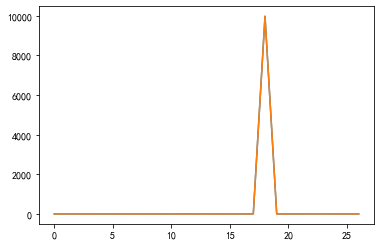

In [34]:
sta = nvb.in_dtime_list(sta,[39])
score_array,groupy = nvp.score(sta,nvm.mae,group_by ="time")
plt.plot(score_array)

上述结果显示有1个时刻的检验指标存在两个异常值导致总体检验结果明显偏高。以下进一步锁定异常的日期

In [35]:
index = np.where(score_array[:,0] > 100)[0]
print(sta.iloc[index,:])

      level                time  dtime     id    lon   lat      ob   ecmwf  \
4638      0 2019-09-27 20:00:00     39  54398  116.6  40.1  9999.0  25.336   

      grapes  
4638  22.568  


通过上述诊断发现，观测值9999是造成检验指标异常的原因，由于9999并不是本系统默认的缺省值（nmb.IV = 999999）,因此在删除缺省值时未未对其进行过滤，为此可以采用如下方式进一步过滤：

In [36]:
sta_all_new = nvb.not_equal_to(sta_all,9999)
sta = nvb.by_loc_dict(sta_all_new,{"hour":[20],"id":[54398]}) #重新从总样本中截取54398站点起报时间为每日20时的样本
result = nvp.score(sta,nvm.mae,group_by = "dtime")   # 计算每个预报时效的平均绝对误差的情况。
print(result)

(array([[2.19057123, 6.61257124],
       [2.03462076, 5.69475872],
       [1.83406882, 4.95710338],
       [1.74548149, 4.12355556],
       [1.22868965, 2.43710349],
       [1.29627595, 2.44800018],
       [1.35034476, 2.41379297],
       [2.47848278, 3.92317245],
       [2.26096569, 4.79834492],
       [2.25682754, 4.4231724 ],
       [2.05641374, 4.03379309],
       [2.19724145, 3.92648283],
       [1.55944827, 2.52937925],
       [1.40938466, 2.38538459],
       [1.43671421, 2.51271428],
       [2.38414284, 4.13400001],
       [2.20786194, 4.9439999 ],
       [2.27944835, 4.41627586],
       [2.70700003, 4.78628566],
       [1.8092413 , 3.86165508],
       [1.38666674, 2.1293333 ],
       [1.37820689, 2.36703462],
       [1.14969241, 2.43846148],
       [1.78784613, 3.70661537],
       [2.07942863, 4.18414284]]), [[0], [3], [6], [9], [12], [15], [18], [21], [24], [27], [30], [33], [36], [39], [42], [45], [48], [51], [54], [57], [60], [63], [66], [69], [72]])


In [37]:
result = nvp.score(sta,nvm.cr,para1 = [0,10]) # ecmwf和grapes被视作一个集合预报的两个成员
print(result)    #shape = (len(para1))

(array([0.9280245 , 0.83429672]), None)


从上面的示例中可以看出，基于本程序库提供的函数，实现了数据收集、数据提取和检验计算代码的解耦，使得我们检验分析的过程变得十分灵活，同时解耦也为各部分的进一步模块化提供了基础。值得注意的是采用上述方法进行检验时，会出现如下几个方面的问题：  
    1，将数据全部收集到sta_all变量当中,需要内存足够大  
    2，当sta_all太大时，从中做数据选取，速度会变慢   
    3，不能计算和存储检验中间检验量，也因此不能开展并行计算  
    4，目前只能支持按一个纬度进行简单的分组，不能按多个维度同时分组，例如将样本同时按月份和时效进行分组的功能无法提供。 
上述问题可以在更上一层（nmc_vf_report）中提供解决方案  